In [1]:
import os
import sys
import numpy as np
import pandas as pd
import math
import sys
import pickle
import csv

import dask.dataframe as dd
from dask.distributed import Client

import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.nn import PyroModule
from pyro.infer import Predictive

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

sys.path.insert(0, '/home/djl34/lab_pd/kl/git/KL/scripts')
import raklette
from run_raklette import run_raklette
from run_raklette import TSVDataset

sys.path.insert(0, '/home/djl34/lab_pd/simulator/code')
from others import round_sig

import matplotlib.pyplot as plt

##############################################################################################################
## Useful transformations
####################################################
pad = torch.nn.ConstantPad1d((1,0), 0.)           # Add a 0 to a tensor
softmax = torch.nn.Softmax(-1)                    # softmax transform along the last dimension
relu = torch.nn.ReLU()                            # map everything < 0 -> 0
order_trans = dist.transforms.OrderedTransform()  # y_0=x_0; y_i=y_0+sum_j=1^i exp(x_j) [not really used anymore, weird properties]


KL_data_dir = "/home/djl34/lab_pd/kl/data"
scratch_dir = "/n/scratch3/users/d/djl34"

base_set = ["A", "C", "T", "G"]
chrom_set = [str(x) for x in range(1, 23)]
# chrom_set = ["22"]

In [2]:
client = Client()

## get beta

In [ ]:
# [os.path.join(KL_data_dir, "raklette_output/" + file_directory + "phyloP_phyloPsq_phylo6_" + 
#               chrom + "_sample_10000000_covonly_lr_0.01_gamma_0.5_chunksize_10000_epoch_1_covprior_0.1.pkl") for chrom in chrom_set],
# [os.path.join(KL_data_dir, "raklette_output/" + file_directory + "phyloP_phyloPsq_phylo6_" + chrom + 
#               "_sample_20000000_covonly_lr_0.01_gamma_0.5_chunksize_10000_epoch_1_covprior_0.1.pkl") for chrom in chrom_set],
# [os.path.join(KL_data_dir, "raklette_output/" + file_directory + "phyloP_phyloPsq_phylo6_" + chrom + 
#               "_sample_10000000_covonly_lr_0.01_gamma_0.1_chunksize_10000_epoch_1_covprior_0.1.pkl") for chrom in chrom_set],
# [os.path.join(KL_data_dir, "raklette_output/" + file_directory + "phyloP_phyloPsq_phylo6_" + chrom + 
#               "_sample_10000000_covonly_lr_0.01_gamma_0.5_chunksize_20000_epoch_1_covprior_0.1.pkl") for chrom in chrom_set],

# (10000, 10000000, 0.5)

In [45]:
chrom_set = ["-2"]
even_chrom_set = [str(2 * x) for x in range(1, 12)]
chrom_set = even_chrom_set

file_directory = "single_feature/zoonomia/"
header = "phyloP_phyloPsq_phylo6_"

epoch = 1
chunksize = 10000
sample_size = 10000000
gamma = 0.1
header_list = [os.path.join(KL_data_dir, "raklette_output/" + file_directory + header + chrom + "_sample_"+ 
                            str(sample_size) + "_covonly_lr_0.01_gamma_" + str(gamma) +"_chunksize_"+ str(chunksize)+"_epoch_" + 
                            str(epoch)+ "_covprior_0.1") for chrom in chrom_set]

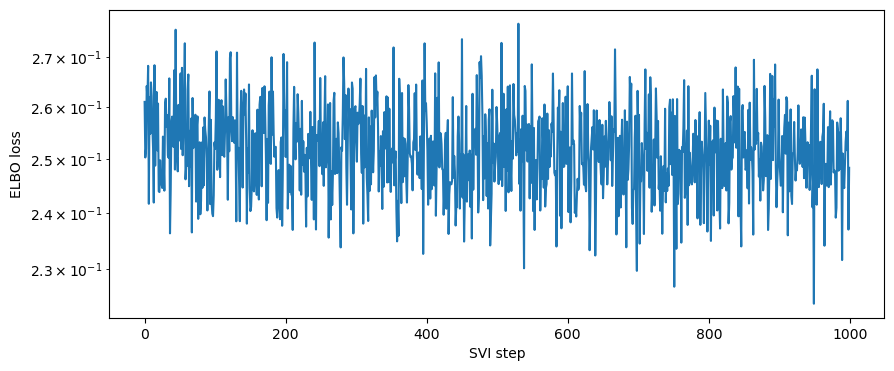

In [46]:
with open(header_list[0] + ".pkl", 'rb') as handle:
            dictionary = pickle.load(handle)

In [47]:
# for i in range(len(header_list)):
#     print(i)
#     try:
#         with open(header_list[i] + ".pkl", 'rb') as handle:
#             dictionary = pickle.load(handle)
#     except:
#         print("continue")
#         continue

In [48]:
def read_model(file_header):
    
    with open(file_header + ".model", 'rb') as handle:
        dictionary = pickle.load(handle)
    
    return dictionary

def get_n_cov(dictionary):
    
    guide = dictionary["guide"]
    KL = dictionary["KL"]
    model = dictionary["model"]

    beta_neut = KL.beta_neut
    beta_neut_full = KL.beta_neut_full
    beta_cov = guide.median()['beta_cov']
    
    return beta_cov.shape[0]

def get_beta_cov_trans(dictionary):
    
    with open(file_header + ".model", 'rb') as handle:
        dictionary = pickle.load(handle)
    
    guide = dictionary["guide"]
    KL = dictionary["KL"]
    model = dictionary["model"]

    beta_neut = KL.beta_neut
    beta_neut_full = KL.beta_neut_full
    beta_cov = guide.median()['beta_cov']
    
    beta_cov_trans = torch.cumsum(beta_cov, dim=-1)
    
    return beta_cov_trans

def get_n_sites(file_header):
    
    variants = "/n/scratch3/users/d/djl34/kl_input/"+ file_directory + file_header + "_length.tsv"
    
    df = pd.read_csv(variants, sep = "\t", header = None)
    
    print(df)
    
    return int(df.iloc[0, 0])
    

In [49]:

list_of_list = []

for chrom in chrom_set:
        
        list_row = []
        list_row.append(int(chrom))
        
        file_header = os.path.join(KL_data_dir, "raklette_output/" + file_directory + header + 
                                   chrom + "_sample_" + str(sample_size) + 
                                   "_covonly_lr_0.01_gamma_" + str(gamma) +"_chunksize_"+ str(chunksize)+"_epoch_" + 
                                   str(epoch)+ "_covprior_0.1")
        
        dictionary = read_model(file_header)        
        n_cov = get_n_cov(dictionary)
        beta_cov_trans = get_beta_cov_trans(dictionary)
        
        for i in range(n_cov):
            list_row.append(round_sig(float(beta_cov_trans[i, 0]), 2))
            list_row.append(round_sig(float(beta_cov_trans[i, -1]), 2))
        
        
        list_row.append(get_n_sites(header + chrom + "_sample_" + str(sample_size)))
        
        list_of_list.append(list_row)
    
    

          0
0  10000000
1         5
         0
0  9999990
1        5
          0
0  10000000
1         5
          0
0  10000000
1         5
         0
0  9999999
1        5
          0
0  10000000
1         5
          0
0  10000000
1         5
          0
0  10000000
1         5
         0
0  9999996
1        5
          0
0  10000000
1         5
          0
0  10000000
1         5


In [50]:
columns_list = ["Chrom"]

for i in range(n_cov):
    columns_list.extend(["beta_" + str(i) + "_initial", "beta_" + str(i) + "_final"])
columns_list.append("sites")

df = pd.DataFrame(list_of_list, columns = columns_list)

In [51]:
df

,Chrom,beta_0_initial,beta_0_final,beta_1_initial,beta_1_final,beta_2_initial,beta_2_final,sites
0,2,0.16,0.52,0.14,0.48,0.13,0.45,10000000
1,4,0.16,0.51,0.13,0.46,0.12,0.45,9999990
2,6,0.17,0.52,0.14,0.47,0.12,0.46,10000000
3,8,0.16,0.52,0.13,0.46,0.12,0.45,10000000
4,10,0.17,0.54,0.14,0.47,0.12,0.44,9999999
5,12,0.19,0.54,0.15,0.49,0.12,0.45,10000000
6,14,0.18,0.54,0.15,0.49,0.12,0.45,10000000
7,16,0.15,0.53,0.15,0.50,0.13,0.46,10000000
8,18,0.16,0.52,0.13,0.47,0.12,0.45,9999996
9,20,0.17,0.53,0.14,0.48,0.12,0.45,10000000


In [52]:
guide = dictionary["guide"]
KL = dictionary["KL"]
model = dictionary["model"]

beta_neut = KL.beta_neut
beta_neut_full = KL.beta_neut_full
beta_cov = guide.median()['beta_cov']

In [53]:
guide.quantiles([0.5])["beta_cov"]

tensor([[[0.1865, 0.1302, 0.1222, 0.1145],
         [0.1555, 0.1212, 0.1126, 0.1134],
         [0.1329, 0.1120, 0.1110, 0.1120]]])

In [32]:
# create a function for final beta

def phyloP_to_beta(x, phylop6):
    
    x = x/8.903
    
    if phylop6:
        return df["beta_0_final"].mean() * x + df["beta_1_final"].mean() * (x**2) + df["beta_2_final"]
    else:
        return df["beta_0_final"].mean() * x + df["beta_1_final"].mean() * (x**2)

### plot largest beta bin to middle phyloP

In [35]:
df_interval = pd.read_csv("../zoonomia_gene_edges_interval_betas.tsv", sep = "\t")

In [36]:
df_interval["PhyloP_middle"] = (df_interval["PhyloP_lower"] + df_interval["PhyloP_upper"])/2

ValueError: operands could not be broadcast together with shapes (1000,) (11,) 

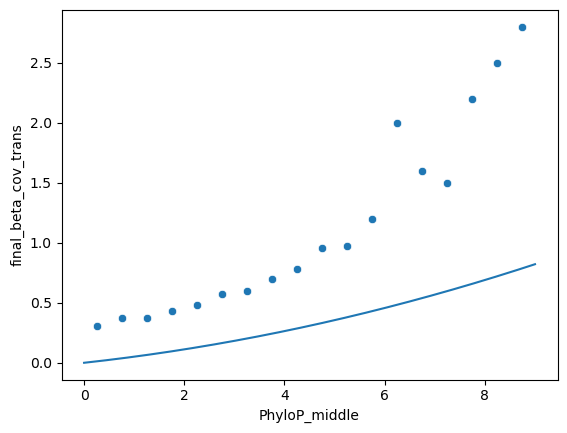

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df_interval, x="PhyloP_middle", y="final_beta_cov_trans")

x = np.linspace(0, 9.0, 1000)
y = phyloP_to_beta(x, False)

plt.plot(x, y)

x = np.linspace(6.0, 6.4, 1000)
y = phyloP_to_beta(x, True)

plt.plot(x, y)


# plt.yscale('log')

<AxesSubplot:xlabel='PhyloP_lower', ylabel='initial_beta_cov_trans'>

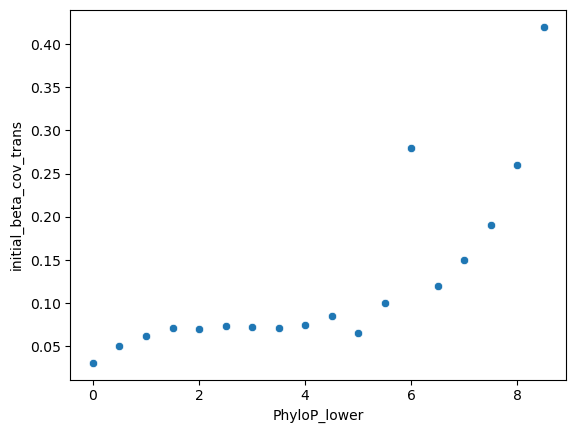

In [47]:
sns.scatterplot(data=df, x="PhyloP_lower", y="initial_beta_cov_trans")

# plt.yscale('log')

<AxesSubplot:xlabel='PhyloP_lower', ylabel='sites'>

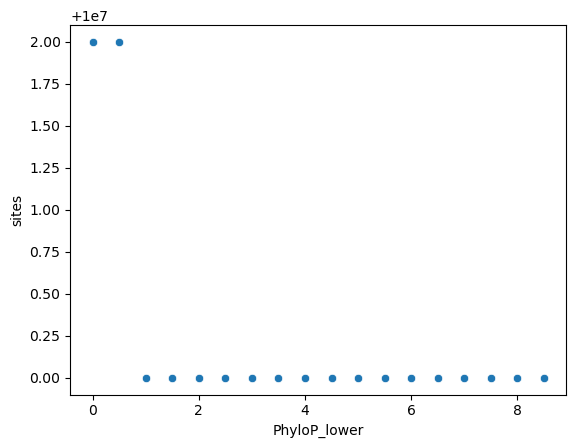

In [48]:
sns.scatterplot(data=df, x="PhyloP_lower", y="sites")